<a href="https://colab.research.google.com/github/arifpras/ExpectedDemand/blob/main/20240308_podem01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="markdown-google-sans">

  <h1> Predicting Demand in the Primary Market: Pycaret</h1>
</div>

<div class="markdown-google-sans">

## <strong> Data Preparation </strong>
</div>

## Libraries

In [2]:
%%capture

# !pip install -U scikit-learn==0.24.2
# !pip install -U imbalanced-learn

# %pip install openpyxl
# %pip install shap
# %pip install pycaret

!pip show pycaret || pip install pycaret

In [3]:
# Subsequent cells can use the installed library
import pycaret
pycaret.__version__

'3.3.0'

In [4]:
from pycaret.regression import *

import numpy as np
import pandas as pd
import openpyxl as xl
import matplotlib.pyplot as plt
import seaborn as sns

## Database

### Load

In [5]:
df_train00 = pd.read_excel('/content/drive/MyDrive/00database/db_monthfrac.xlsx', sheet_name='database')
df_train00['incoming_bid'] = df_train00['incoming_bid'].astype(float)
df_train00['issuance_date'] = pd.to_datetime(df_train00['issuance_date'], format='%Y-%m-%d')

df_train00.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1924 entries, 0 to 1923
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   issued_series     1924 non-null   object        
 1   issuance_date     1924 non-null   datetime64[ns]
 2   issuance_year     1924 non-null   int64         
 3   issuance_week     1924 non-null   int64         
 4   monthfrac         1924 non-null   int64         
 5   eid_weeks         1924 non-null   int64         
 6   srbi_issuance     1924 non-null   int64         
 7   vix_indicator     1924 non-null   int64         
 8   bi_covid          1924 non-null   int64         
 9   gso_issuance      1924 non-null   int64         
 10  investment_grade  1924 non-null   int64         
 11  incoming_bid      1924 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(9), object(1)
memory usage: 180.5+ KB


In [7]:
df_train00['issued_series'].value_counts()

sun10    296
sun20    291
spn12    276
sun15    276
sun05    270
spn03    242
sun30    174
spn09     76
sun07     11
sun08      9
sun04      1
vr04       1
sun02      1
Name: issued_series, dtype: int64

In [8]:
df_train00.describe()

,issuance_year,issuance_week,monthfrac,eid_weeks,srbi_issuance,vix_indicator,bi_covid,gso_issuance,investment_grade,incoming_bid
count,1924.000000,1924.000000,1924.000000,1924.000000,1924.000000,1924.000000,1924.000000,1924.000000,1924.000000,1.924000e+03
mean,2017.242204,24.384096,124.373181,0.082640,0.041060,0.081081,0.245322,0.022349,0.862266,6.290073e+06
std,4.322848,14.125527,108.472144,0.275409,0.198481,0.273031,0.430390,0.147855,0.344710,5.927125e+06
min,2009.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,2014.000000,12.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.396975e+06
50%,2018.000000,24.000000,119.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.434650e+06
75%,2021.000000,37.000000,188.250000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,8.009500e+06
max,2024.000000,51.000000,367.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.516780e+07


<Axes: xlabel='incoming_bid', ylabel='issuance_week'>

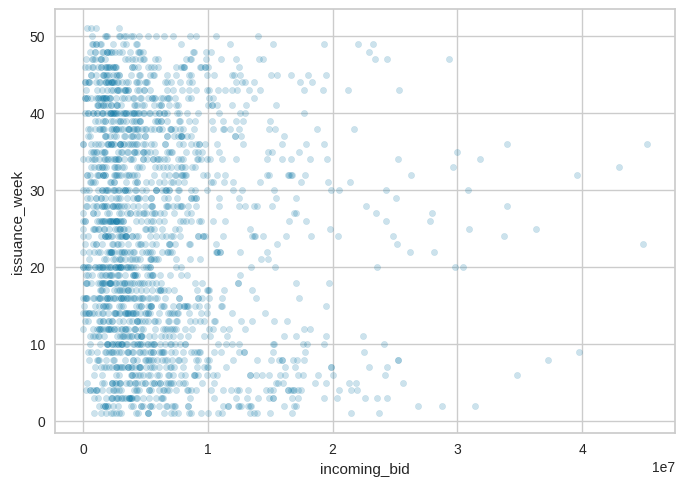

In [9]:
df_train00.plot(kind = 'scatter', x = 'incoming_bid', y = 'issuance_week', alpha = 0.2)

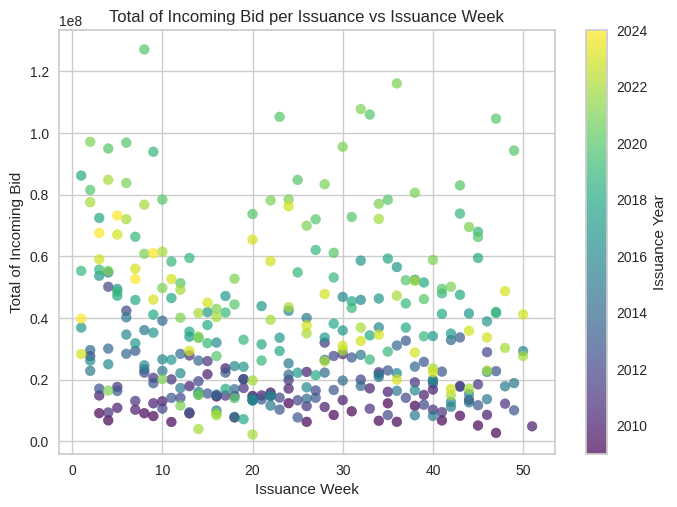

In [10]:
# import matplotlib.pyplot as plt

grouped_series01 = df_train00.groupby(['issuance_date']).agg({
    'incoming_bid': 'sum',
    'issuance_week': 'mean',
    'issuance_year': 'mean'
}).reset_index()

# Convert 'issuance_year' to integer
grouped_series01['issuance_year'] = grouped_series01['issuance_year'].astype(int)


# Scatter plot
# plt.figure(figsize=(10, 6))
plt.scatter(grouped_series01['issuance_week'], grouped_series01['incoming_bid'], s=50, c=grouped_series01['issuance_year'], alpha=0.7, cmap='viridis')
plt.title('Total of Incoming Bid per Issuance vs Issuance Week')
plt.xlabel('Issuance Week')
plt.ylabel('Total of Incoming Bid')
plt.colorbar(label='Issuance Year')
plt.grid(True)
plt.show()

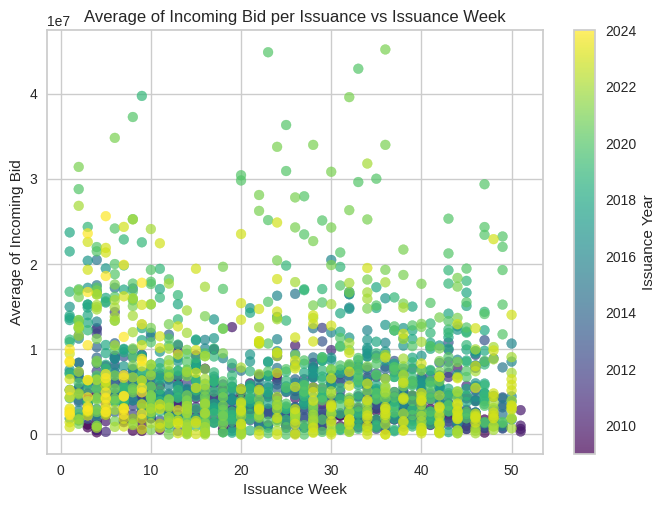

In [11]:
# import matplotlib.pyplot as plt

grouped_series02 = df_train00.groupby(['issuance_date', 'issued_series']).agg({
    'incoming_bid': 'mean', #average
    'issuance_week': 'mean',
    'issuance_year': 'mean'
}).reset_index()

# Convert 'issuance_year' to integer
grouped_series02['issuance_year'] = grouped_series02['issuance_year'].astype(int)


# Scatter plot
# plt.figure(figsize=(10, 6))
plt.scatter(grouped_series02['issuance_week'], grouped_series02['incoming_bid'], s=50, c=grouped_series02['issuance_year'], alpha=0.7, cmap='viridis')
plt.title('Average of Incoming Bid per Issuance vs Issuance Week')
plt.xlabel('Issuance Week')
plt.ylabel('Average of Incoming Bid')
plt.colorbar(label='Issuance Year')
plt.grid(True)
plt.show()

In [ ]:
# sns.catplot(x='issued_series', y='incoming_bid', data=grouped_series02,
#                 kind='boxen', col='issuance_year', col_wrap=2)

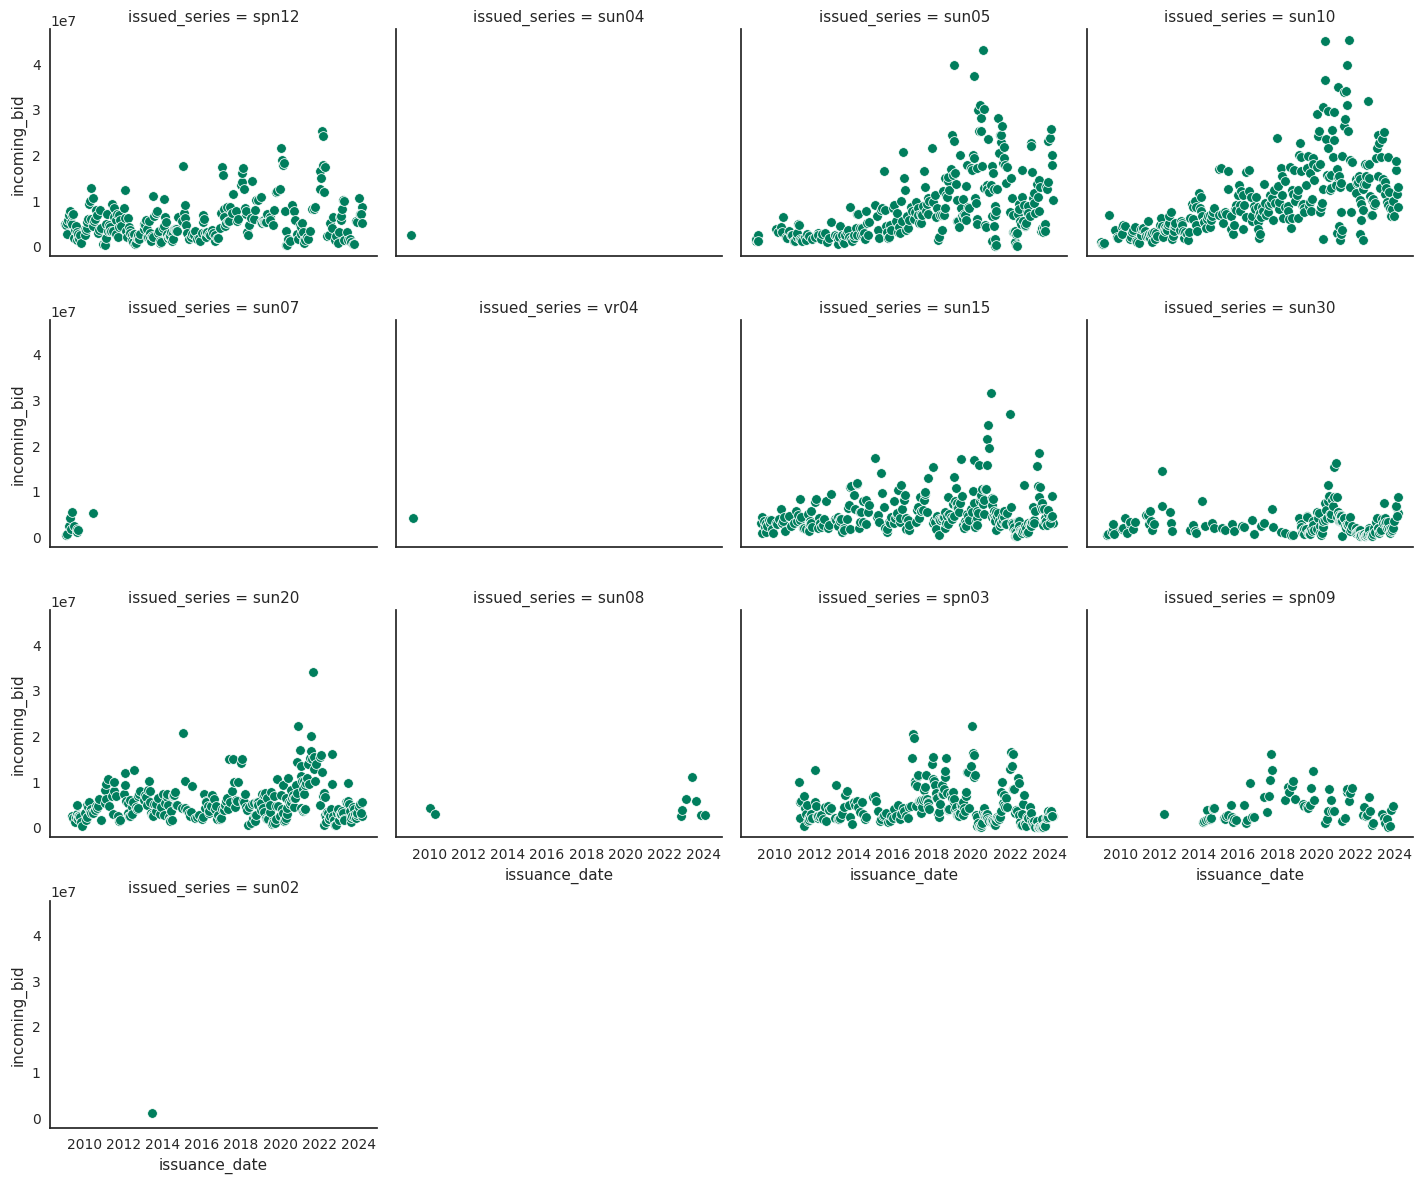

In [12]:
# import seaborn as sns
# import matplotlib.pyplot as plt

sns.set_style("white")

# Create a FacetGrid and use map to create subplots based on 'FacetVar'
ch01 = sns.FacetGrid(df_train00, col='issued_series', col_wrap=4, height=3, aspect=1.2)
ch01.map(sns.scatterplot, 'issuance_date', 'incoming_bid', color='#007e5d')

# Show the plot
# plt.show()


In [13]:
corr_matrix = df_train00.corr()
corr_matrix['incoming_bid'].sort_values(ascending=False)

incoming_bid        1.000000
issuance_year       0.250193
investment_grade    0.193264
bi_covid            0.173530
eid_weeks          -0.011979
srbi_issuance      -0.012210
vix_indicator      -0.049892
issuance_week      -0.099794
gso_issuance       -0.100542
monthfrac          -0.102366
Name: incoming_bid, dtype: float64

In [14]:
df_train01 = df_train00[~df_train00['issued_series'].isin(['sun04', 'sun02', 'vr04', 'spn09', 'sun07'])]

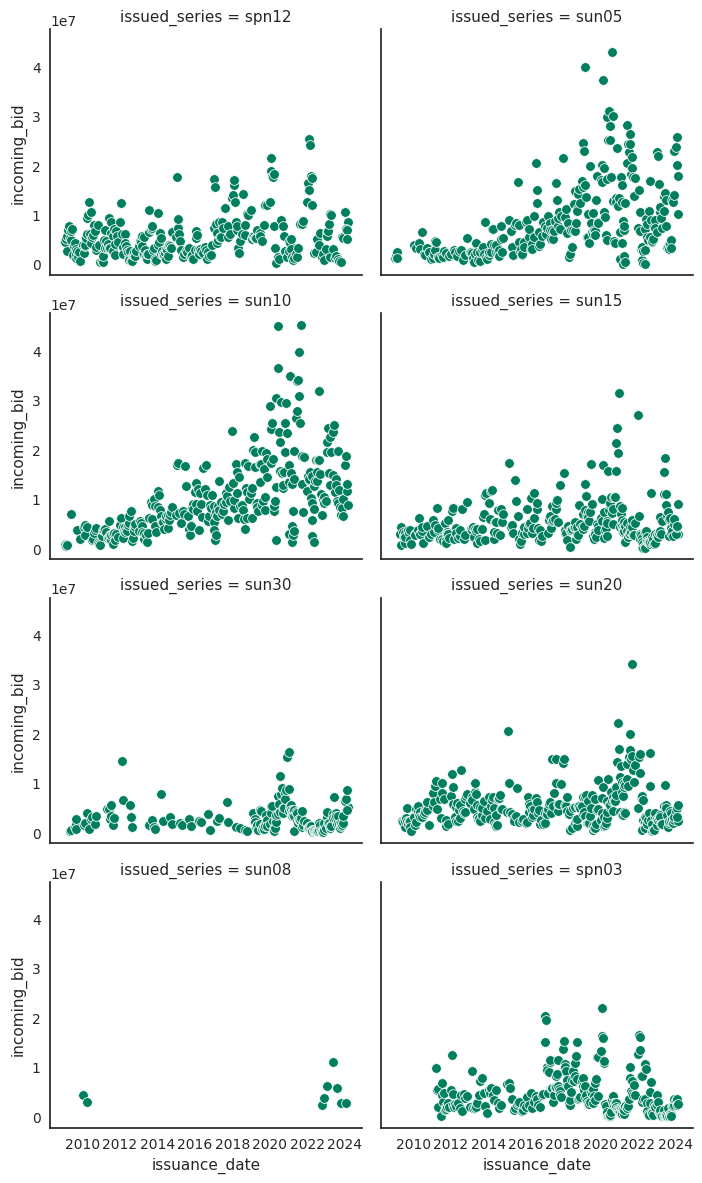

In [15]:
# import seaborn as sns
# import matplotlib.pyplot as plt

sns.set_style("white")

# Create a FacetGrid and use map to create subplots based on 'FacetVar'
ch02 = sns.FacetGrid(df_train01, col='issued_series', col_wrap=2, height=3, aspect=1.2)
ch02.map(sns.scatterplot, 'issuance_date', 'incoming_bid', color='#007e5d')

# Show the plot
# plt.show()


In [16]:
# Get the order of categories
issd_series = df_train01['issued_series'].unique()

# Sort the order
issd_series.sort()

# Create a boxplot with sorted order
# sns.boxplot(x='issued_series', y='incoming_bid', data=df_train01,
#             order=issd_series, hue='issuance_year')

# sns.boxplot(x='issued_series', y='incoming_bid', data=df_train01,
#             order=issd_series)
# plt.show()

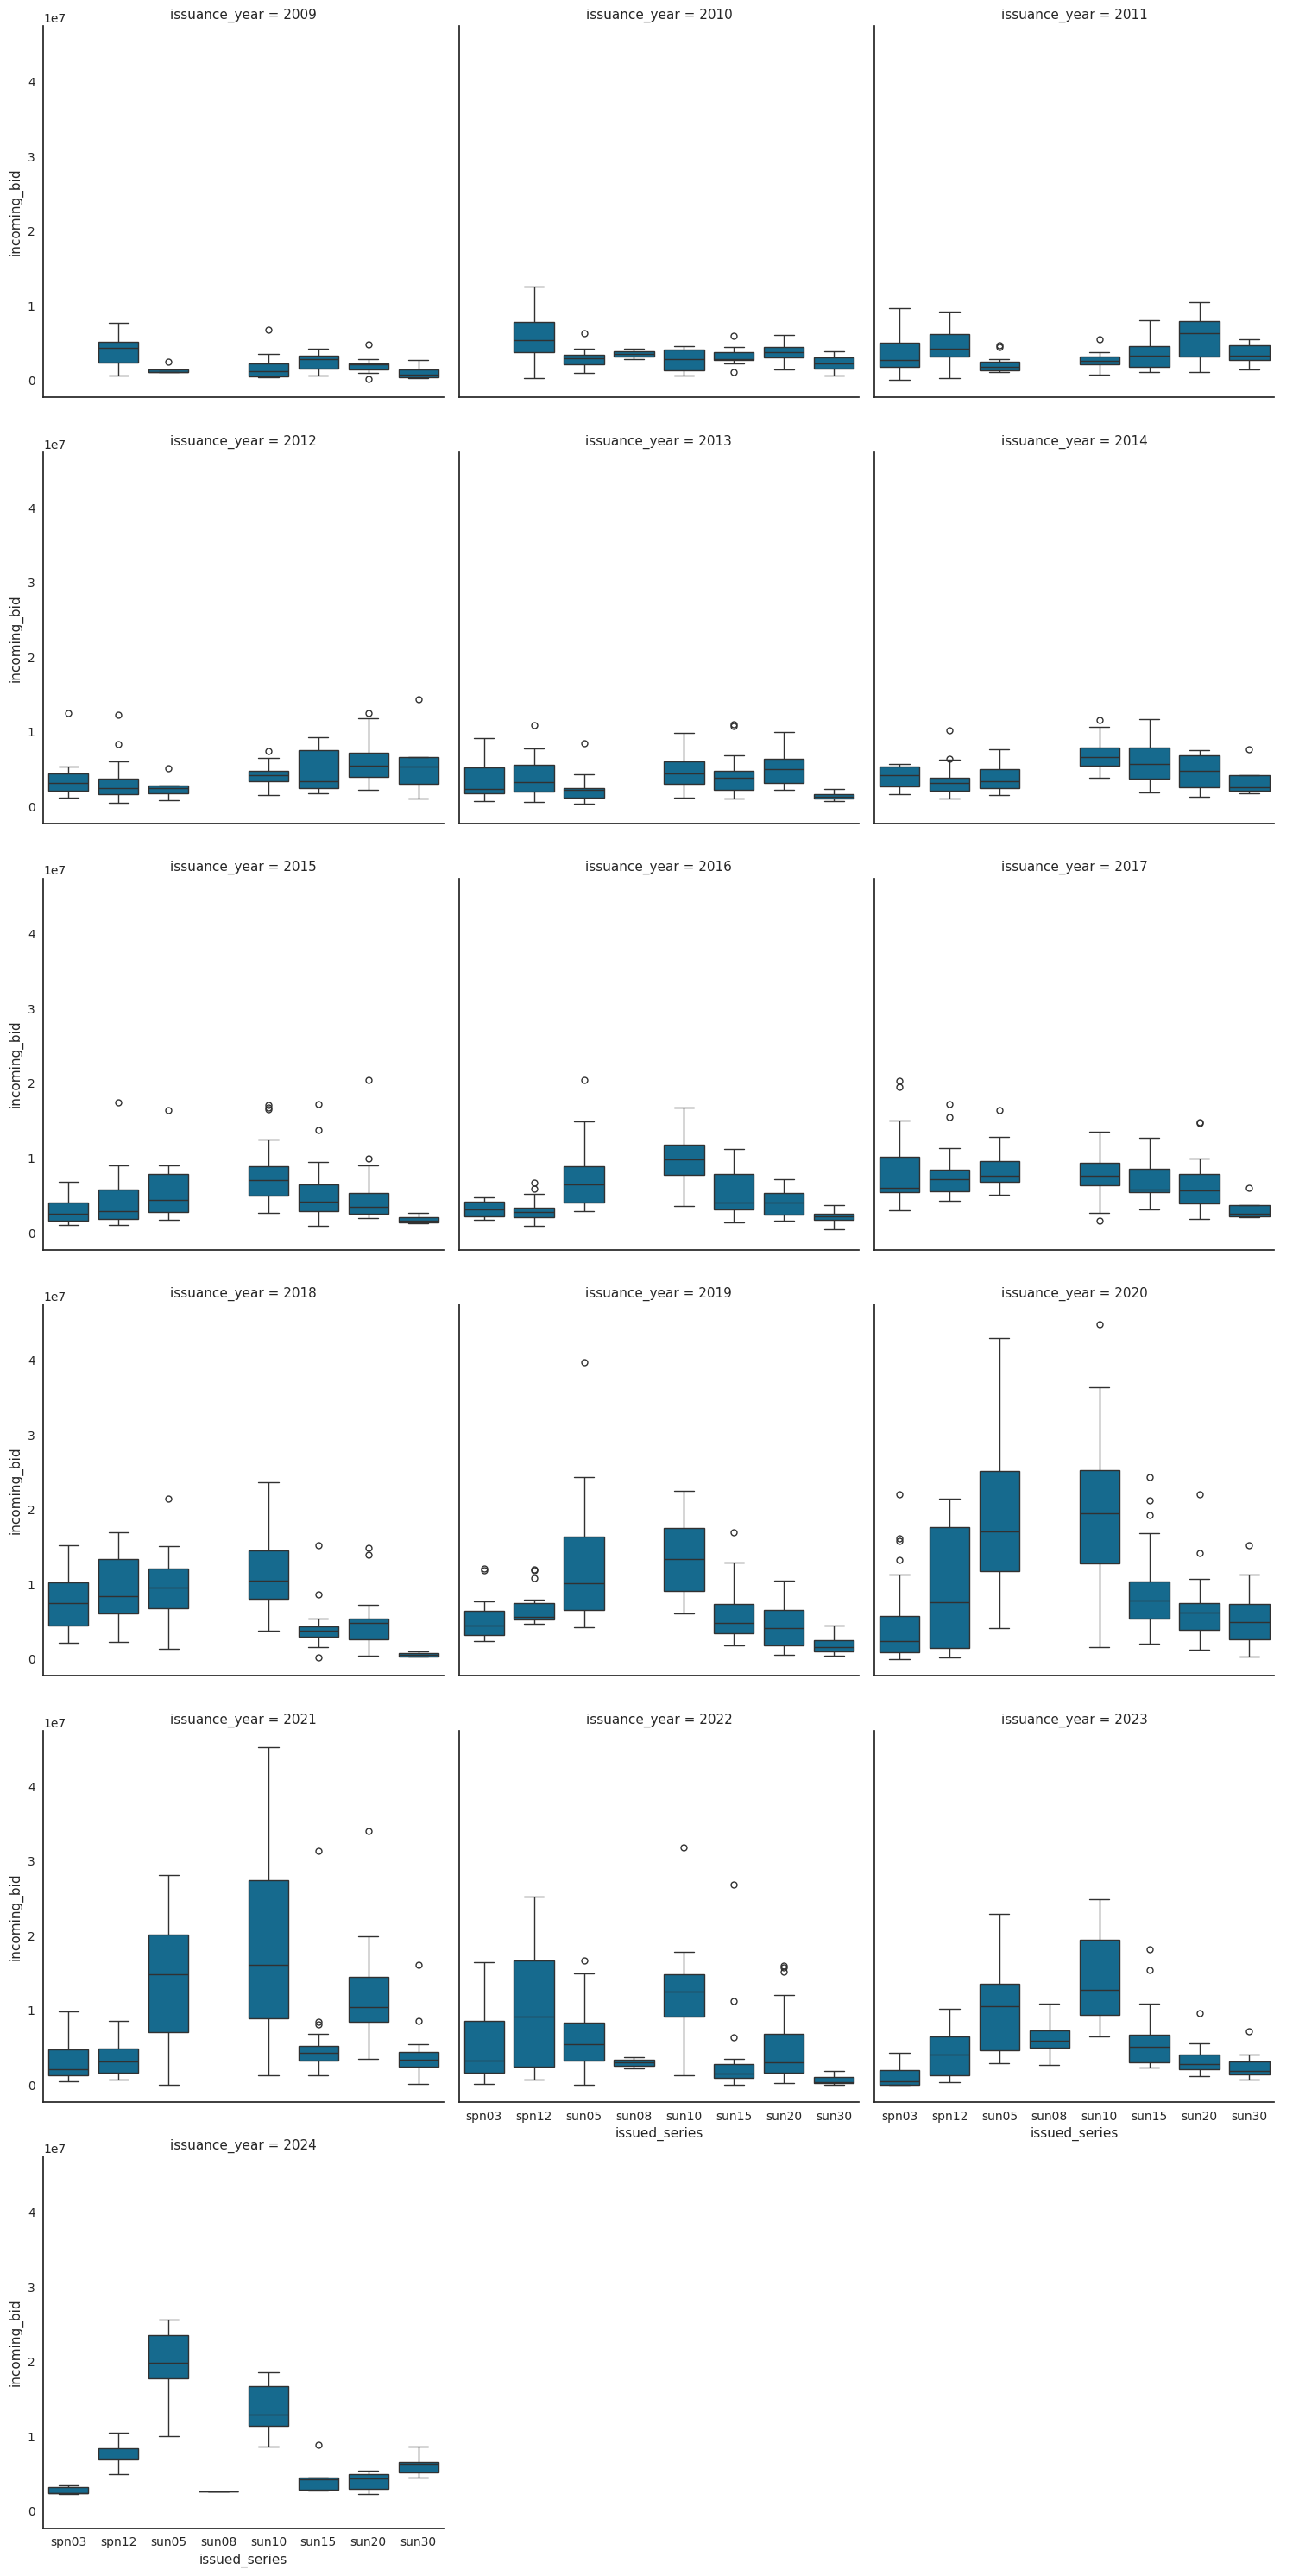

In [17]:
sns.catplot(x='issued_series', y='incoming_bid', data=df_train01,
                order=issd_series, kind='box', col='issuance_year', col_wrap=3)

### Split: Biased

In [ ]:
# df_train02 = df_train01.sample(frac=0.9, random_state=786)
# df_unseen01 = df_train01.drop(df_train02.index)

# df_train02.reset_index(drop=True, inplace=True)
# df_unseen01.reset_index(drop=True, inplace=True)

# print('Data for Modeling: ' + str(df_train02.shape))
# print('Unseen Data For Predictions: ' + str(df_unseen01.shape))

In [ ]:
# print("Train: \n{} \n\nTest: \n{}".format(df_train02['issued_series'].value_counts(), df_unseen01['issued_series'].value_counts()))

### Split: Stratified

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit

# Assuming df is your DataFrame and 'target_column' is the target variable
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

for train_index, test_index in split.split(df_train01, df_train01['issued_series']):
    # Explicitly reset the index
    df_train02 = df_train01.iloc[train_index]
    df_unseen01 = df_train01.iloc[test_index]

# Explicitly reset the index for df_train02 and df_test01
# df_train02 = df_train02.reset_index(drop=True)
# df_unseen01 = df_unseen01.reset_index(drop=True)

# Display the shapes of the resulting sets (optional)
print("Train set shape:", df_train02.shape)
print("Test set shape:", df_unseen01.shape)

Train set shape: (1650, 12)
Test set shape: (184, 12)


In [19]:
print("Train: \n{} \n\nTest: \n{}".format(df_train02['issued_series'].value_counts(), df_unseen01['issued_series'].value_counts()))

Train: 
sun10    266
sun20    262
spn12    248
sun15    248
sun05    243
spn03    218
sun30    157
sun08      8
Name: issued_series, dtype: int64 

Test: 
sun10    30
sun20    29
sun15    28
spn12    28
sun05    27
spn03    24
sun30    17
sun08     1
Name: issued_series, dtype: int64


In [20]:
# Identifying duplicates
duplicates = df_train02[df_train02.index.duplicated()]
print("Rows with duplicate indices:")
print(duplicates)


Rows with duplicate indices:
Empty DataFrame
Columns: [issued_series, issuance_date, issuance_year, issuance_week, monthfrac, eid_weeks, srbi_issuance, vix_indicator, bi_covid, gso_issuance, investment_grade, incoming_bid]
Index: []


In [21]:
# Identifying duplicates
duplicates = df_unseen01[df_unseen01.index.duplicated()]
print("Rows with duplicate indices:")
print(duplicates)

Rows with duplicate indices:
Empty DataFrame
Columns: [issued_series, issuance_date, issuance_year, issuance_week, monthfrac, eid_weeks, srbi_issuance, vix_indicator, bi_covid, gso_issuance, investment_grade, incoming_bid]
Index: []


# Methods

## Setup

In [22]:
session01 = setup(data=df_train02, target='incoming_bid', session_id=123,
                  test_data=df_unseen01,
                  categorical_features=['issued_series'],
                  ignore_features = ['issuance_date'])

,Description,Value
0,Session id,123
1,Target,incoming_bid
2,Target type,Regression
3,Original data shape,"(1834, 12)"
4,Transformed data shape,"(1834, 18)"
5,Transformed train set shape,"(1650, 18)"
6,Transformed test set shape,"(184, 18)"
7,Ignore features,1
8,Numeric features,9
9,Categorical features,1


## Compare Models

In [23]:
best01 = compare_models(sort = 'rmse')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,2334222.1077,12267038306211.9883,3492171.4474,0.6558,1.1088,0.8864,0.4920
lightgbm,Light Gradient Boosting Machine,2376818.6187,12429083013330.8496,3512313.1229,0.6530,1.1275,0.9417,0.6630
et,Extra Trees Regressor,2343377.5342,12406641805879.4570,3513355.3179,0.6485,1.0079,0.6969,0.4140
xgboost,Extreme Gradient Boosting,2373055.1750,12938907222016.0000,3584779.5750,0.6342,1.1407,0.8780,0.1330
gbr,Gradient Boosting Regressor,2900787.7402,17578351218651.6934,4173764.6147,0.5157,1.2433,1.1636,0.2270
knn,K Neighbors Regressor,3069298.1250,19467074220851.1992,4402324.3250,0.4522,1.2797,1.8991,0.1200
dt,Decision Tree Regressor,2984258.0000,21511919743060.6016,4618407.8632,0.3888,1.2665,0.8358,0.0990
ada,AdaBoost Regressor,4052354.1194,26094922331254.8789,5097118.2273,0.2707,1.5137,3.2591,0.2310
lasso,Lasso Regression,3681585.2124,26566195256163.6953,5136115.1349,0.2660,1.4555,2.3932,0.0820
lr,Linear Regression,3682014.2347,26567201869308.6250,5136218.9940,0.2660,1.4557,2.3933,0.8030


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

## Features

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2453803.9215,15344639603371.0312,3917223.4559,0.5486,1.1880,0.7226
1,2321998.4686,10723438903031.8008,3274666.2277,0.6354,2.2578,0.8620
2,2437035.5862,13034847446369.0547,3610380.5127,0.7336,0.6530,0.7200
3,2382821.7161,11739350933745.6602,3426273.6221,0.5769,0.8156,1.2007
4,2507273.0873,12128304669178.8398,3482571.5598,0.7151,1.2321,1.1423
5,2531093.0026,16332363552588.8730,4041331.9033,0.6307,1.9905,1.7140
6,2278369.3968,11351319310746.5098,3369171.9028,0.7103,0.6701,0.9218
7,2304846.6590,10571195587363.9492,3251337.5075,0.6821,1.2245,0.5949
8,2362596.8989,14071603216226.7246,3751213.5658,0.6308,0.6840,0.9447


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

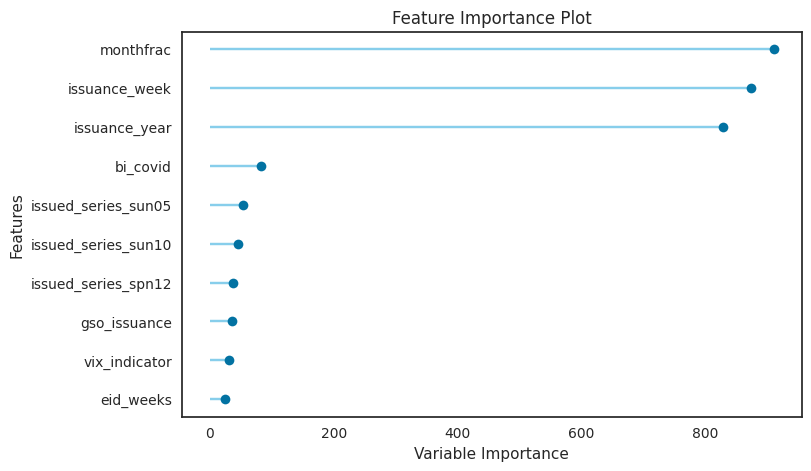

In [24]:
plot_model(create_model('lightgbm'), plot='feature')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2512763.2500,16644724228096.0000,4079794.7500,0.5104,1.1843,0.7002
1,2169151.5000,9210756595712.0000,3034922.7500,0.6868,2.3304,0.9012
2,2246200.0000,12176676880384.0000,3489509.5000,0.7512,0.6143,0.6320
3,2321750.5000,12953444155392.0000,3599089.2500,0.5331,0.8067,0.9157
4,2279528.0000,10928511778816.0000,3305830.0000,0.7432,1.1678,0.9956
5,2491443.2500,15495138902016.0000,3936386.5000,0.6496,1.9203,1.5052
6,2400614.5000,12085387853824.0000,3476404.5000,0.6916,0.7620,0.9950
7,2499654.7500,12912883138560.0000,3593450.0000,0.6117,1.3444,0.6049
8,2411472.7500,15125774860288.0000,3889187.0000,0.6031,0.6629,0.8770


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

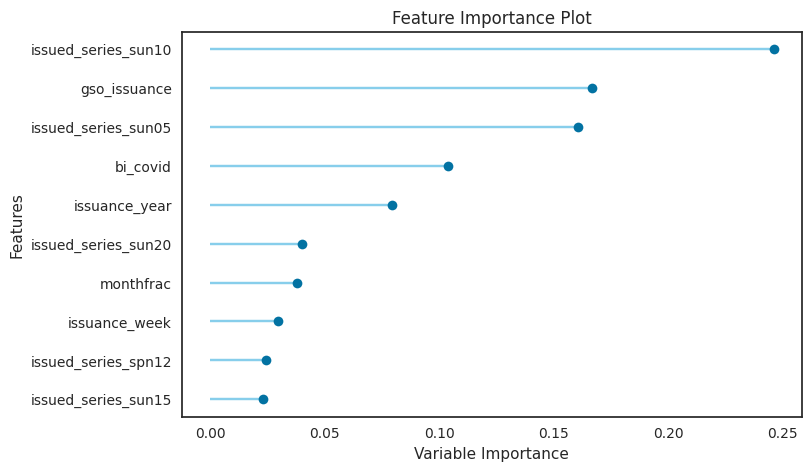

In [25]:
plot_model(create_model('xgboost'), plot='feature')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2422107.3818,14245944836018.5703,3774380.0598,0.5809,1.0796,0.6792
1,2146477.5364,9189916207746.0684,3031487.4580,0.6875,1.9098,0.6656
2,2259443.4606,11690945959841.7637,3419202.5327,0.7611,0.5670,0.5864
3,2205874.3455,10742249072669.4277,3277537.0437,0.6128,0.7175,0.7215
4,2562367.6667,13041315727022.2246,3611276.1909,0.6936,0.9964,0.7550
5,2421452.3636,13053372098486.6914,3612945.0727,0.7048,1.8772,0.8518
6,2068507.9030,10807638692865.4902,3287497.3297,0.7242,0.6711,0.9536
7,2458519.5818,12231580844506.3945,3497367.7022,0.6322,1.0653,0.5461
8,2503422.4485,15236106330089.1738,3903345.5305,0.6002,0.5862,0.6027


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

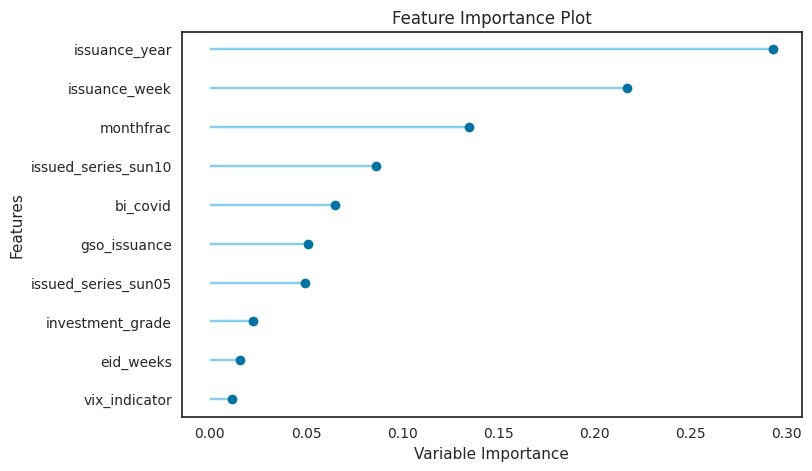

In [26]:
plot_model(create_model('et'), plot='feature')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2451444.7020,15931528926685.9297,3991431.9394,0.5313,1.1799,0.7684
1,2148222.8162,9281575217974.4434,3046567.7767,0.6844,2.3084,0.7704
2,2309517.4146,12506099514624.8672,3536396.4024,0.7444,0.6172,0.6862
3,2310341.7409,11971323624026.0098,3459960.0610,0.5685,0.6722,0.8488
4,2481187.6433,12368925341650.2539,3516948.2995,0.7094,1.2359,0.9598
5,2473894.6434,14231247209602.8809,3772432.5321,0.6782,2.0124,1.9342
6,2358195.5400,12231638644882.2695,3497375.9656,0.6879,0.6971,0.9896
7,2251615.4180,10476974228154.3008,3236815.4455,0.6849,1.1666,0.5505
8,2299642.6867,13483493403403.5586,3671987.6638,0.6462,0.6090,0.6912


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

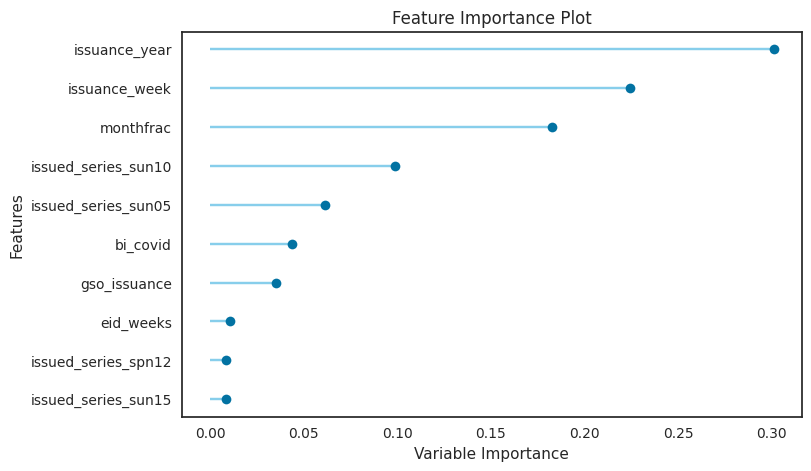

In [27]:
plot_model(create_model('rf'), plot='feature')

# Algorithms

## Light Gradient Boosting Machine

### Raw -- 65.30%

In [28]:
# train a xgb model with default params
lightgbm_raw = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2453803.9215,15344639603371.0312,3917223.4559,0.5486,1.1880,0.7226
1,2321998.4686,10723438903031.8008,3274666.2277,0.6354,2.2578,0.8620
2,2437035.5862,13034847446369.0547,3610380.5127,0.7336,0.6530,0.7200
3,2382821.7161,11739350933745.6602,3426273.6221,0.5769,0.8156,1.2007
4,2507273.0873,12128304669178.8398,3482571.5598,0.7151,1.2321,1.1423
5,2531093.0026,16332363552588.8730,4041331.9033,0.6307,1.9905,1.7140
6,2278369.3968,11351319310746.5098,3369171.9028,0.7103,0.6701,0.9218
7,2304846.6590,10571195587363.9492,3251337.5075,0.6821,1.2245,0.5949
8,2362596.8989,14071603216226.7246,3751213.5658,0.6308,0.6840,0.9447


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Tuning -- 59.11%

In [29]:
# tune hyperparameters of lightgbm
lightgbm_tuned = tune_model(lightgbm_raw)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2893284.8311,19251004070520.0430,4387596.6167,0.4337,1.2803,0.9944
1,2487075.0695,11840463271295.2461,3440997.4239,0.5974,2.3693,1.1333
2,2820821.4474,15454446347898.0312,3931214.3605,0.6842,0.8418,0.8859
3,2849244.6595,15901661819647.7695,3987688.7817,0.4269,0.8832,1.2188
4,2584614.5978,11641349553880.6445,3411942.1967,0.7265,1.3350,3.5142
5,2831608.5855,17561290581212.2246,4190619.3553,0.6029,2.0233,2.0548
6,2567833.5584,15468114665428.8281,3932952.4108,0.6053,0.9580,0.9292
7,2646222.6120,13191761048320.9434,3632046.3995,0.6033,1.3521,0.6436
8,2724443.0111,15769383400099.7539,3971068.2946,0.5863,0.7449,0.9923


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Modifying -- 65.95%

In [30]:

# Define a more comprehensive tuning grid for LightGBM
lightgbm_grid = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.5],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9, 11],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.01, 0.001],
    'reg_lambda': [1, 1.5, 2, 3, 4],
    'num_leaves': [15, 31, 63, 127],
    'min_split_gain': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample_freq': [0, 1, 2],
}

# Tune LightGBM model with custom grid and optimize for R2
lightgbm_modified = tune_model(lightgbm_raw, custom_grid=lightgbm_grid, optimize='mse', early_stopping=True, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2540238.6438,16198551730575.2324,4024742.4428,0.5235,1.3132,0.7583
1,2290214.3827,10354544955967.0703,3217847.8764,0.6479,2.2562,0.9681
2,2364945.3631,11758971114814.7812,3429135.6221,0.7597,0.7252,0.7560
3,2344159.2035,11903269699408.3672,3450111.5488,0.5710,0.8243,1.0106
4,2457735.6173,11549726045910.7637,3398488.7886,0.7286,1.3357,0.9459
5,2554741.6544,15446945656151.2344,3930260.2530,0.6507,2.0389,0.9784
6,2257741.4045,10594677597535.4336,3254946.6351,0.7296,0.6613,0.7969
7,2193893.6700,9929414870177.4629,3151097.4073,0.7014,1.1488,0.5366
8,2419681.0123,14240173630380.2363,3773615.4587,0.6264,0.7248,0.9382


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


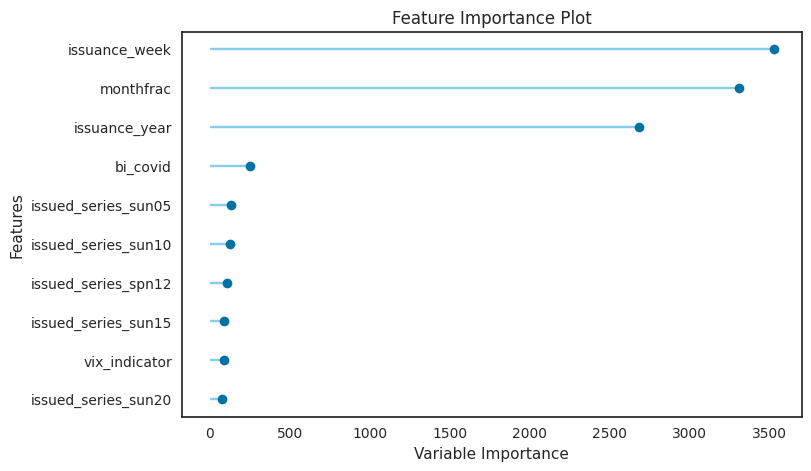

In [31]:
plot_model(lightgbm_modified, plot = 'feature')

### Bagging -- 64.90%

In [32]:
# ensemble with bagging
lightgbm_bagged = ensemble_model(lightgbm_raw, method = 'Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2411234.7018,14379660092969.8887,3792052.2271,0.5770,1.1487,0.6630
1,2314478.5434,10289958271527.3477,3207796.4822,0.6501,2.0902,0.9779
2,2482682.5100,13413010378217.6602,3662377.6946,0.7259,0.6604,0.7783
3,2424800.9483,11943553585212.7402,3455944.6733,0.5695,0.7489,1.1608
4,2539799.8872,12593881698081.4023,3548785.9471,0.7041,1.0289,0.7349
5,2602358.1084,16928297008575.9453,4114401.1725,0.6172,2.0269,1.7888
6,2293405.5253,12063259015268.5312,3473220.2659,0.6922,0.6565,0.8817
7,2392197.1802,11021605159926.6035,3319880.2930,0.6686,1.2772,0.5896
8,2379109.9589,13869648313497.2402,3724197.6738,0.6361,0.6506,0.8248


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### Boosting -- 65.06%

In [33]:
# ensemble with boosting
lightgbm_boosted = ensemble_model(lightgbm_raw, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2487337.0119,16241152258309.7637,4030031.2974,0.5222,0.9393,0.8539
1,2347968.3343,10602535391024.0332,3256153.4655,0.6395,2.2980,0.9979
2,2386650.5819,11538169497677.4512,3396788.1149,0.7642,0.7788,0.7787
3,2570105.5045,13616590267797.4414,3690066.4314,0.5092,0.7279,1.0925
4,2534315.0042,12152393693554.0371,3486028.3552,0.7145,1.2088,1.1538
5,2606612.5873,14900737616094.7207,3860147.3568,0.6630,2.0740,1.1205
6,2286134.4531,11089027769416.8203,3330019.1845,0.7170,0.7396,0.9547
7,2174847.4725,8680501707164.5332,2946269.1166,0.7390,1.2470,0.5966
8,2397430.7988,13812433426428.1934,3716508.2304,0.6376,0.6679,0.8208


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

## Extreme Gradient Boosting

### Raw -- 63.42%

In [34]:
# train a xgb model with default params
xgb_raw = create_model('xgboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2512763.2500,16644724228096.0000,4079794.7500,0.5104,1.1843,0.7002
1,2169151.5000,9210756595712.0000,3034922.7500,0.6868,2.3304,0.9012
2,2246200.0000,12176676880384.0000,3489509.5000,0.7512,0.6143,0.6320
3,2321750.5000,12953444155392.0000,3599089.2500,0.5331,0.8067,0.9157
4,2279528.0000,10928511778816.0000,3305830.0000,0.7432,1.1678,0.9956
5,2491443.2500,15495138902016.0000,3936386.5000,0.6496,1.9203,1.5052
6,2400614.5000,12085387853824.0000,3476404.5000,0.6916,0.7620,0.9950
7,2499654.7500,12912883138560.0000,3593450.0000,0.6117,1.3444,0.6049
8,2411472.7500,15125774860288.0000,3889187.0000,0.6031,0.6629,0.8770


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Tuning -- 65.79%

In [35]:
# tune hyperparameters of xgb
xgb_tuned = tune_model(xgb_raw)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2571300.7500,16036009082880.0000,4004498.5000,0.5283,1.3111,0.7592
1,2076190.6250,9084478685184.0000,3014047.0000,0.6911,2.3618,0.6608
2,2131043.5000,10203887042560.0000,3194352.2500,0.7915,0.6546,0.6188
3,2309902.7500,12408006377472.0000,3522500.0000,0.5528,0.6920,0.7128
4,2316322.5000,9776483270656.0000,3126736.7500,0.7703,1.2730,0.6931
5,2537500.5000,14467783983104.0000,3803654.0000,0.6728,2.0267,0.8741
6,2276040.2500,10007389143040.0000,3163445.7500,0.7446,0.9932,0.9470
7,2346515.7500,12276864122880.0000,3503835.7500,0.6308,1.1028,0.5756
8,2307084.0000,13954381250560.0000,3735556.2500,0.6339,0.5615,0.5219


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


### Modifying -- 66.85%

In [36]:
# define a more comprehensive tuning grid for XGBoost
xgb_grid = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.5],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9, 11],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.1, 0.01, 0.001],
    'reg_lambda': [1, 1.5, 2, 3, 4]
}

# tune model with custom grid and optimize for R2
xgb_modified = tune_model(xgb_raw, custom_grid=xgb_grid, optimize='mse', early_stopping=True, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2370846.7500,15789650345984.0000,3973619.2500,0.5355,1.1849,0.7567
1,2112115.5000,8895378489344.0000,2982512.0000,0.6975,2.1920,0.8189
2,2311133.0000,11844922114048.0000,3441645.2500,0.7579,0.6840,0.6963
3,2465303.5000,12645840191488.0000,3556099.0000,0.5442,0.7144,0.8919
4,2441869.2500,11505486528512.0000,3391973.7500,0.7297,1.1195,1.3689
5,2489338.2500,15584516374528.0000,3947723.0000,0.6476,1.9524,1.1056
6,2243474.5000,11655516782592.0000,3414017.7500,0.7026,0.6920,0.8994
7,2189380.7500,9383297679360.0000,3063217.0000,0.7178,1.1526,0.5412
8,2460108.7500,13165003800576.0000,3628361.0000,0.6546,0.6923,0.9490


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


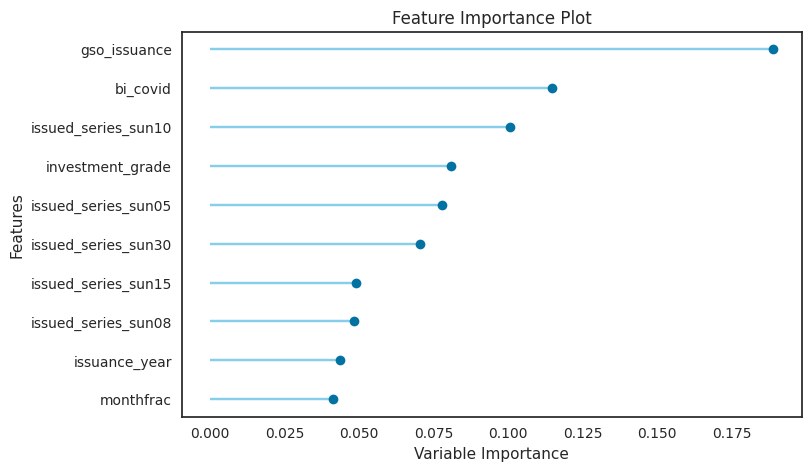

In [37]:
plot_model(xgb_modified, plot = 'feature')

### Bagging -- 66.70%

In [38]:
# ensemble with bagging
xgb_bagged = ensemble_model(xgb_raw, method = 'Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2299425.2500,13380279599104.0000,3657906.5000,0.6064,0.9268,0.6668
1,2177669.5000,9220409786368.0000,3036512.7500,0.6865,2.2851,0.8388
2,2132625.5000,11229599891456.0000,3351059.5000,0.7705,0.6424,0.6509
3,2368827.0000,11714851504128.0000,3422696.5000,0.5778,0.6411,0.7396
4,2375392.2500,11281416323072.0000,3358782.0000,0.7349,1.1690,0.7875
5,2514840.5000,16121794134016.0000,4015195.5000,0.6354,2.0248,1.1311
6,2361673.5000,12761075548160.0000,3572264.7500,0.6744,0.6979,0.9401
7,2252887.2500,10118465847296.0000,3180953.5000,0.6957,1.1407,0.5263
8,2275359.0000,13509505056768.0000,3675527.7500,0.6455,0.6203,0.7403


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### Boosting -- 67.03%

In [39]:
# ensemble with boosting
xgb_boosted = ensemble_model(xgb_raw, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2357090.5000,14687349506048.0000,3832407.7500,0.5679,1.2086,0.7580
1,2118865.0000,9204995719168.0000,3033973.5000,0.6870,2.3969,0.8627
2,2071798.1250,10549791293440.0000,3248044.2500,0.7844,0.5983,0.5970
3,2343562.7500,12137957163008.0000,3483957.0000,0.5625,0.6477,0.7391
4,2401252.5000,10629023793152.0000,3260218.2500,0.7503,1.1611,0.9756
5,2491707.2500,14317270335488.0000,3783817.0000,0.6762,2.0574,1.1083
6,2274948.0000,11119806644224.0000,3334637.5000,0.7162,0.6795,0.9173
7,2278194.0000,9894380961792.0000,3145533.5000,0.7024,1.1244,0.5599
8,2354413.0000,13758284955648.0000,3709216.2500,0.6390,0.6702,0.7573


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

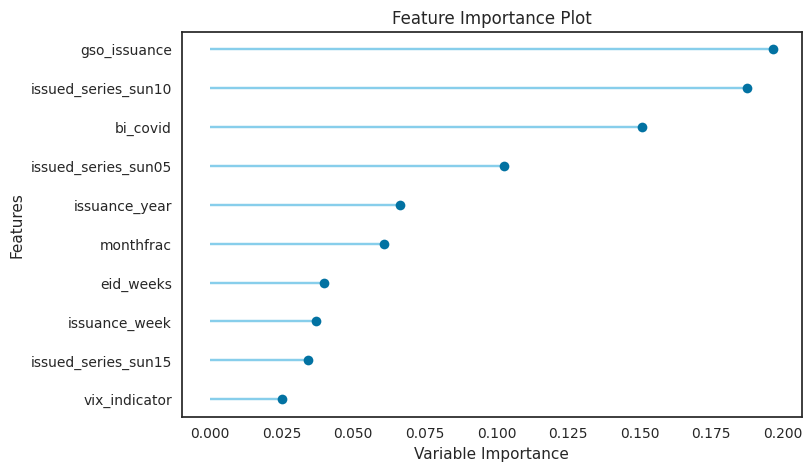

In [40]:
plot_model(xgb_boosted, plot = 'feature')

## Extra Trees Regressor

### Raw -- 64.85%

In [41]:
# train a et model with default params
et_raw = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2422107.3818,14245944836018.5703,3774380.0598,0.5809,1.0796,0.6792
1,2146477.5364,9189916207746.0684,3031487.4580,0.6875,1.9098,0.6656
2,2259443.4606,11690945959841.7637,3419202.5327,0.7611,0.5670,0.5864
3,2205874.3455,10742249072669.4277,3277537.0437,0.6128,0.7175,0.7215
4,2562367.6667,13041315727022.2246,3611276.1909,0.6936,0.9964,0.7550
5,2421452.3636,13053372098486.6914,3612945.0727,0.7048,1.8772,0.8518
6,2068507.9030,10807638692865.4902,3287497.3297,0.7242,0.6711,0.9536
7,2458519.5818,12231580844506.3945,3497367.7022,0.6322,1.0653,0.5461
8,2503422.4485,15236106330089.1738,3903345.5305,0.6002,0.5862,0.6027


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Tuning -- 54.79%

In [42]:
# tune hyperparameters of et
et_tuned = tune_model(et_raw)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2633732.7130,16877365738981.2871,4108207.1198,0.5035,1.3340,0.9608
1,2619119.7044,12102577300784.6387,3478875.8674,0.5885,2.4501,1.2069
2,2853336.1249,18271624617182.9414,4274532.0934,0.6266,0.7859,1.1498
3,2804116.7991,14411557624639.6602,3796255.7375,0.4806,0.8241,1.2588
4,2990211.0476,17657931826763.2227,4202134.1990,0.5851,1.4086,3.6382
5,2973021.6745,20453230631984.1016,4522524.8072,0.5375,2.2093,2.6358
6,2735589.4475,17454694647851.4629,4177881.5981,0.5546,0.8066,1.2823
7,2793612.5022,14621510611231.8652,3823808.3910,0.5603,1.2986,0.6651
8,2574254.3511,16283184236690.6816,4035242.7730,0.5728,0.7260,1.0188


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Modifying -- 61.97%

In [43]:
# define a more comprehensive tuning grid for Random Forest Regressor
et_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 4, 8, 12],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt', None],
    'bootstrap': [True, False]
}

# Tune model with the optimized grid and optimize for Mean Squared Error (mse)
et_modified = tune_model(et_raw, custom_grid=et_grid, optimize='mse', early_stopping=True, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2641348.2480,16508869454096.7207,4063110.8100,0.5143,1.2660,1.0067
1,2328755.6886,9810332776540.9609,3132145.0759,0.6664,2.3170,0.9688
2,2468664.1687,14286918380248.0977,3779804.0135,0.7080,0.6876,0.8785
3,2454930.1361,11972142719373.8711,3460078.4268,0.5685,0.7583,1.2160
4,2858556.0660,16205278394916.1758,4025578.0200,0.6193,1.3262,1.8620
5,2745393.3904,18297571845811.7383,4277566.1124,0.5862,2.1181,2.3292
6,2427319.9909,15184250221841.1523,3896697.3480,0.6125,0.7435,1.1351
7,2364577.6127,10664442527237.6035,3265645.8055,0.6793,1.2382,0.5855
8,2393793.1405,14714757705723.8906,3835981.9741,0.6139,0.6767,0.8691


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Bagging -- 65.97%

In [44]:
# ensemble with bagging
et_bagged = ensemble_model(et_raw, method = 'Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2439696.8871,14168705699902.4238,3764134.1235,0.5832,1.0899,0.7004
1,2158608.3401,9486448863415.7148,3080007.9324,0.6774,2.1632,0.7041
2,2156148.8613,11774128268199.5566,3431344.9649,0.7594,0.5935,0.6586
3,2273099.7210,11150114128240.6367,3339178.6607,0.5981,0.6572,0.8310
4,2475956.3785,12258443853642.1953,3501206.0570,0.7120,1.1554,0.9046
5,2546876.0366,15621068307756.0703,3952349.7198,0.6467,1.9911,1.3508
6,2162304.4946,11883958130217.9512,3447311.7251,0.6967,0.6845,0.9884
7,2263451.9760,9979937169762.3047,3159103.8555,0.6999,1.1229,0.5345
8,2264016.2763,13137744201989.7422,3624602.6268,0.6553,0.6021,0.6581


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### Boosting -- 64.66%

In [45]:
# ensemble with boosting
et_boosted = ensemble_model(et_raw, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2512136.5475,14577144477754.9570,3818002.6817,0.5712,1.1593,0.7297
1,2242344.4219,9746903159991.7891,3122003.0685,0.6686,2.1417,0.6850
2,2182208.4788,10651652768300.0977,3263686.9899,0.7823,0.5592,0.5936
3,2167153.2743,10296997973561.5664,3208893.5747,0.6289,0.6472,0.7889
4,2506901.8182,12631281924158.6914,3554051.4802,0.7032,1.2045,0.9804
5,2545909.8182,15553417737851.7695,3943782.1616,0.6483,1.9958,1.5575
6,2162507.9265,11820908609706.5098,3438154.8263,0.6983,0.6817,0.9796
7,2441936.5606,11705304329510.3535,3421301.5549,0.6480,1.1478,0.5520
8,2389702.9499,14417479973138.8125,3797035.6824,0.6217,0.5957,0.6403


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

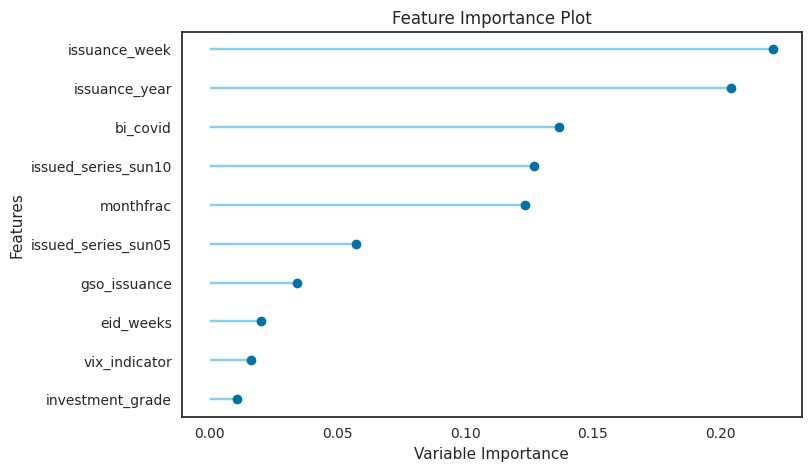

In [46]:
plot_model(et_boosted, plot = 'feature')

## Random Forest Regressor

### Raw -- 65.58%

In [47]:
# train a rf model with default params
rf_raw = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2451444.7020,15931528926685.9297,3991431.9394,0.5313,1.1799,0.7684
1,2148222.8162,9281575217974.4434,3046567.7767,0.6844,2.3084,0.7704
2,2309517.4146,12506099514624.8672,3536396.4024,0.7444,0.6172,0.6862
3,2310341.7409,11971323624026.0098,3459960.0610,0.5685,0.6722,0.8488
4,2481187.6433,12368925341650.2539,3516948.2995,0.7094,1.2359,0.9598
5,2473894.6434,14231247209602.8809,3772432.5321,0.6782,2.0124,1.9342
6,2358195.5400,12231638644882.2695,3497375.9656,0.6879,0.6971,0.9896
7,2251615.4180,10476974228154.3008,3236815.4455,0.6849,1.1666,0.5505
8,2299642.6867,13483493403403.5586,3671987.6638,0.6462,0.6090,0.6912


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Tuning -- 58.28%

In [48]:
# tune hyperparameters of rf
rf_tuned = tune_model(rf_raw)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2490640.8780,15542227296256.7207,3942363.1614,0.5428,1.3029,0.9046
1,2539892.0987,11620581165100.5117,3408897.3533,0.6049,2.4614,1.2188
2,2786941.8188,17703829138845.8359,4207591.8456,0.6382,0.7522,1.0137
3,2825914.9716,15093082146266.8125,3884981.6147,0.4560,0.7996,1.1693
4,2714611.8201,14699570453442.1992,3834001.8849,0.6546,1.3564,2.5935
5,2955111.8212,19835438298317.8438,4453699.3947,0.5514,2.2201,2.8379
6,2594745.5459,15294672305039.3633,3910840.3579,0.6097,0.7688,1.1549
7,2744630.5824,14228675690810.7598,3772091.6864,0.5721,1.3339,0.6929
8,2454131.4484,14668724570008.7734,3829977.0978,0.6151,0.6642,0.8709


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Modifying -- 64.21%

In [49]:
# define a more comprehensive tuning grid for Random Forest Regressor
rf_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 4, 8, 12, 16],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Tune model with the optimized grid and optimize for Mean Squared Error (mse)
rf_modified = tune_model(rf_raw, custom_grid=rf_grid, optimize='mse', early_stopping=True, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2439386.2672,15970594927403.9941,3996322.6756,0.5302,1.2219,0.7789
1,2199396.0197,9772551889652.6582,3126108.1059,0.6677,2.3308,0.8199
2,2375403.3160,13363056321558.6914,3655551.4388,0.7269,0.6418,0.7399
3,2404801.1205,12449329966836.7695,3528360.8045,0.5513,0.6914,0.8979
4,2557670.2845,13262251908808.7988,3641737.4849,0.6884,1.2608,1.0705
5,2573131.7453,15641480186069.0918,3954931.1228,0.6463,2.0625,2.2251
6,2427555.4740,12976267497405.2539,3602258.6661,0.6689,0.7091,1.0108
7,2318078.7075,11082135403114.5879,3328984.1398,0.6667,1.2112,0.5837
8,2307979.0930,13732417789772.5430,3705727.7004,0.6397,0.6226,0.7178


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Bagging -- 63.53%

In [50]:
# ensemble with bagging
rf_bagged = ensemble_model(rf_raw, method = 'Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2424934.7730,15262758691000.1348,3906758.0794,0.5510,1.2205,0.8271
1,2287658.3505,9806342724873.4316,3131508.0592,0.6666,2.3763,0.9090
2,2424246.0276,13706060836547.9629,3702169.7471,0.7199,0.6874,0.8672
3,2516280.6729,12848801464934.0156,3584522.4877,0.5369,0.7335,1.0197
4,2592566.8720,13010182220901.2539,3606963.0191,0.6943,1.2711,1.4697
5,2673440.9587,16811200477734.7383,4100146.3971,0.6198,2.1059,2.2964
6,2445697.6759,13754350397431.2422,3708685.8046,0.6490,0.7250,1.0575
7,2375204.1671,10847371901023.8340,3293534.8641,0.6738,1.2241,0.6079
8,2346855.5045,13805917617106.9160,3715631.5233,0.6378,0.6415,0.7765


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### Boosting -- 65.29%

In [51]:
# ensemble with boosting
rf_boosted = ensemble_model(rf_raw, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2599588.3479,17400105720527.1387,4171343.3952,0.4881,1.2445,0.8868
1,2282812.2004,10363662312210.2520,3219264.2501,0.6476,2.3776,0.8518
2,2308111.4458,11528150992698.1582,3395313.0920,0.7644,0.6632,0.8018
3,2382456.3940,12098624810103.7441,3478307.7509,0.5640,0.7309,1.0069
4,2455101.2537,11604459707973.9902,3406531.9179,0.7274,1.2635,1.5279
5,2551879.3818,14048437625336.5703,3748124.5477,0.6823,2.0575,1.5762
6,2190184.0855,10906093787409.0215,3302437.5524,0.7217,0.6880,0.9890
7,2228961.4320,10213638267582.5254,3195878.3249,0.6928,1.1815,0.5622
8,2315899.6922,13250471081537.0000,3640119.6521,0.6523,0.6413,0.7781


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

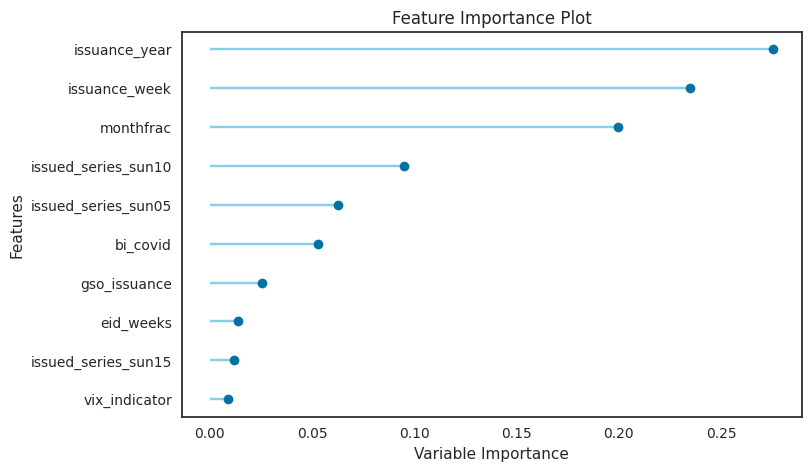

In [52]:
plot_model(rf_boosted, plot = 'feature')

# Choosen

## Blended -- 68.93%

In [53]:
# Blend the Boosted Ensembles
blended = blend_models(estimator_list=[lightgbm_modified, xgb_boosted, et_bagged, rf_raw], fold=10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2334374.3314,14382935066727.0605,3792484.0233,0.5769,1.1487,0.7064
1,2080314.7795,8575254757669.3027,2928353.5916,0.7084,2.2611,0.8000
2,2112254.9461,10728672990969.8672,3275465.3091,0.7807,0.5820,0.6260
3,2223106.9189,10868136193145.6855,3296685.6376,0.6083,0.6060,0.6893
4,2339281.8435,10748595831277.8574,3278505.1214,0.7475,1.0896,0.7365
5,2343057.3551,13409287173612.2402,3661869.3551,0.6968,1.9784,1.3169
6,2152431.9146,10669406460917.5723,3266405.7404,0.7277,0.6443,0.8599
7,2117086.0302,9083800811402.3242,3013934.4405,0.7268,1.0923,0.5146
8,2225055.2050,12674807389807.1973,3560169.5732,0.6674,0.5960,0.7020


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [54]:
predict_model(blended);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,2368762.0556,11055536580304.7129,3324986.7038,0.6466,0.6451,0.6970


In [ ]:
# plot_model(blended, plot = 'residuals')

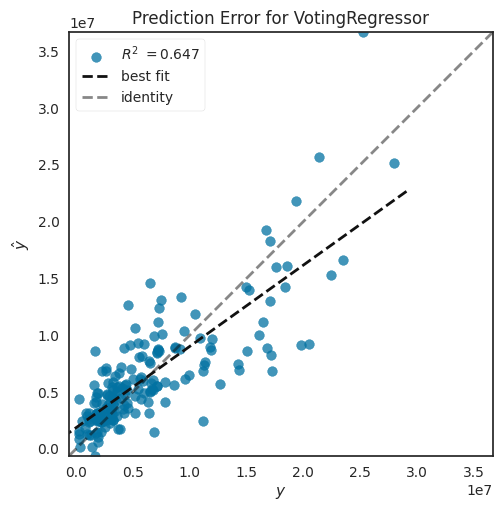

In [55]:
plot_model(blended, plot = 'error')

## Stacked -- 68.28%

In [56]:
stacked = stack_models(estimator_list=[lightgbm_modified, xgb_boosted, et_bagged, rf_raw])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2361279.4962,14339907633889.1484,3786807.0500,0.5782,1.2115,0.6590
1,2102133.7521,9075988029084.4277,3012638.0515,0.6914,2.2698,0.7740
2,2140910.3792,10740969374802.7324,3277341.8154,0.7805,0.5945,0.6651
3,2247126.4652,11057249986581.6641,3325244.3499,0.6015,0.6575,0.7844
4,2329282.4945,10910801938920.0645,3303150.3052,0.7437,1.1979,0.8001
5,2355848.4862,13869630730371.5566,3724195.3131,0.6864,1.9543,1.0335
6,2114588.6003,10411528216911.7812,3226689.9784,0.7343,0.6323,0.8182
7,2119092.8410,8949610400359.4023,2991589.9452,0.7309,1.0270,0.5061
8,2260431.3602,12770928029176.2051,3573643.5230,0.6649,0.6523,0.7311


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [57]:
predict_model(stacked);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,2387450.1265,11427463170720.0020,3380453.1014,0.6347,0.6720,0.6626


In [ ]:
# plot_model(stacked, plot = 'residuals')

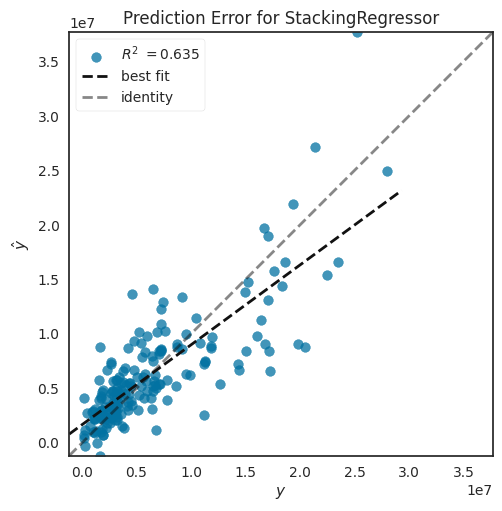

In [58]:
plot_model(stacked, plot = 'error')

## Finalizing -- 94.86%

In [59]:
final = finalize_model(blended)
predict_model(final);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,944947.0406,1607185983275.4734,1267748.3912,0.9486,0.3301,0.2706


In [60]:
save_model(final, '/content/drive/MyDrive/00database/20240308_blended01')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['issuance_year', 'issuance_week',
                                              'monthfrac', 'eid_weeks',
                                              'srbi_issuance', 'vix_indicator',
                                              'bi_covid', 'gso_issuance',
                                              'investment_grade'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['issued_series'],
                                     transformer=SimpleImpute...
                                                                                        monotone_constraints=None,
                                                                                        multi_strategy=None,
                                                                                      

# Lelang 13 Mar 2024

## Load

In [61]:
lelang20240313 = pd.read_excel('/content/drive/MyDrive/00database/db_monthfrac.xlsx', sheet_name='lelang20240313')
lelang20240313['issuance_date'] = pd.to_datetime(lelang20240313['issuance_date'], format='%d/%m/%Y')
lelang20240313.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   issued_series     7 non-null      object        
 1   issuance_date     7 non-null      datetime64[ns]
 2   issuance_year     7 non-null      int64         
 3   issuance_week     7 non-null      int64         
 4   monthfrac         7 non-null      int64         
 5   eid_weeks         7 non-null      int64         
 6   srbi_issuance     7 non-null      int64         
 7   vix_indicator     7 non-null      int64         
 8   bi_covid          7 non-null      int64         
 9   gso_issuance      7 non-null      int64         
 10  investment_grade  7 non-null      int64         
dtypes: datetime64[ns](1), int64(9), object(1)
memory usage: 744.0+ bytes


## Predict

In [62]:
# load model
blended01_20240308 = load_model("/content/drive/MyDrive/00database/20240308_blended01")

# predict model on new_data
predict03= predict_model(blended01_20240308, data = lelang20240313)
predict03

# predict model on new_data
# predict03= predict_model(final, data = lelang20240130)
# predict03

Transformation Pipeline and Model Successfully Loaded


,issued_series,issuance_date,issuance_year,issuance_week,monthfrac,eid_weeks,srbi_issuance,vix_indicator,bi_covid,gso_issuance,investment_grade,prediction_label
0,spn03,2024-03-13,2024,11,3,0,1,0,0,0,1,1.942355e+06
1,spn12,2024-03-13,2024,11,12,0,1,0,0,0,1,8.091228e+06
2,sun05,2024-03-13,2024,11,62,0,1,0,0,0,1,1.622828e+07
3,sun10,2024-03-13,2024,11,120,0,1,0,0,0,1,1.601203e+07
4,sun15,2024-03-13,2024,11,172,0,1,0,0,0,1,6.913360e+06
5,sun20,2024-03-13,2024,11,232,0,1,0,0,0,1,4.447431e+06
6,sun30,2024-03-13,2024,11,365,0,1,0,0,0,1,5.343303e+06


In [63]:
# @title Lelang 20240313: Per series

# !pip install --upgrade pip
# !pip install tabulate

import tabulate

# Incoming bid per series
predict04 = predict03[['issued_series', 'issuance_date', 'prediction_label']]

# Create a new column with formatted dates
predict04['issuance_date'] = predict04['issuance_date'].dt.strftime('%Y-%m-%d')

# Format the 'prediction_label' column
predict04['prediction_label'] = predict04['prediction_label'].apply(lambda x: '{:,.2f} trillion'.format(x / 1_000_000))

# Convert the DataFrame to a list of dictionaries for tabulate
table_data = predict04.to_dict(orient='records')

# Specify the column alignments
column_alignments = {'issued_series': 'left', 'issuance_date': 'center', 'prediction_label': 'right'}

# Display the formatted DataFrame using tabulate
formatted_table = tabulate.tabulate(table_data, headers="keys", floatfmt=".2f", showindex=False, colalign=list(column_alignments.values()), tablefmt="pipe")

print(formatted_table)

| issued_series   |  issuance_date  |   prediction_label |
|:----------------|:---------------:|-------------------:|
| spn03           |   2024-03-13    |      1.94 trillion |
| spn12           |   2024-03-13    |      8.09 trillion |
| sun05           |   2024-03-13    |     16.23 trillion |
| sun10           |   2024-03-13    |     16.01 trillion |
| sun15           |   2024-03-13    |      6.91 trillion |
| sun20           |   2024-03-13    |      4.45 trillion |
| sun30           |   2024-03-13    |      5.34 trillion |


In [64]:
# @title Lelang 20240313: Total

# Sum total incoming bid
incoming_bid = predict03['prediction_label'].sum()

# Round to two decimal places
rounded_bid = round(incoming_bid, 2)
formatted_rounded_bid = 'Rp{:,.2f} million'.format(rounded_bid)

# Adjust to the nearest thousand
formatted_incoming_bid = 'Rp{:,.2f} trillion'.format(rounded_bid / 1000000)

output_message = f"""
According to a blended machine learning algorithm model with an R-squared value of 67.74%,
the estimated incoming bid for the next issuance is approximately {formatted_rounded_bid}
or {formatted_incoming_bid}.
"""

print(output_message)



According to a blended machine learning algorithm model with an R-squared value of 67.74%,
the estimated incoming bid for the next issuance is approximately Rp58,977,994.88 million
or Rp58.98 trillion.

